### Author: Pratham Dedhiya (pdedhiya)

### Multi-View Late Fusion Inference (Dual-View)

**Strategy:** Late Fusion (Decision Level)
**Model:** Pre-trained YOLOv8 (Single View)
**Input:** Paired X-ray images (Orange/Light + Single/Dual)

This model combines predictions from two separate views of the same bag to create a more robust detection system. Since the views are not geometrically aligned (pixel-to-pixel), we fuse the **decisions** (detected classes) rather than the bounding boxes.

**Logic:**
- `Result_Bag = Union(Detect_OL, Detect_SD)`
- If an item is occluded in one view but visible in the other, the system will still catch it.

#### 1. Configuration

In [31]:
import os
import glob
import numpy as np
import random
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix

# Path to point to the best weights
MODEL_PATH = "../yolo/runs/detect/dvxray_yolo_run/weights/best.pt"
VAL_IMG_DIR = "../../data/processed/yolo/images/val"
VAL_LABEL_DIR = "../../data/processed/yolo/labels/val"

# Load Model
model = YOLO(MODEL_PATH)
print(f"Loaded model from {MODEL_PATH}")

Loaded model from ../yolo/runs/detect/dvxray_yolo_run/weights/best.pt


#### 2. Pair Images

In [20]:
# Helper: Pair Images (OL + SD)
def get_image_pairs(img_dir):
    """Finds matching _OL and _SD images based on sample ID."""
    all_files = glob.glob(os.path.join(img_dir, "*.png"))
    pairs = {}
    
    for f in all_files:
        filename = os.path.basename(f)
        if "_OL" in filename:
            sid = filename.replace("_OL.png", "")
            view = "OL"
        elif "_SD" in filename:
            sid = filename.replace("_SD.png", "")
            view = "SD"
        else:
            continue
            
        if sid not in pairs:
            pairs[sid] = {}
        pairs[sid][view] = f
    
    # Filter for complete pairs only
    valid_pairs = {k: v for k, v in pairs.items() if "OL" in v and "SD" in v}
    print(f"Found {len(valid_pairs)} complete dual-view pairs.")
    return valid_pairs

pairs = get_image_pairs(VAL_IMG_DIR)

Found 3200 complete dual-view pairs.


#### 3. Late Fusion Inference Function

In [21]:
def parse_detections(result_obj, model):
    """Parses YOLO result object to extract unique classes and max confidence."""
    found = {}
    for box in result_obj.boxes:
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]
        conf = float(box.conf[0])
        
        # Keep the highest confidence for this class
        if cls_name not in found or conf > found[cls_name]:
            found[cls_name] = conf
    return found

def run_dual_view_inference(sid, pair_paths, model):
    """
    Runs inference on both views and fuses the results.
    Returns: Combined list of unique detected classes and their max confidence.
    """
    img_ol = pair_paths["OL"]
    img_sd = pair_paths["SD"]
    
    # Run Inference (suppress verbose output)
    res_ol = model.predict(img_ol, verbose=False)[0]
    res_sd = model.predict(img_sd, verbose=False)[0]
    
    # --- Fusion Logic (Decision Level) ---
    # We want a dictionary: { 'Gun': 0.95, 'Knife': 0.88 }
    fused_detections = {}
    
    # Pass 'model' to helper
    det_ol = parse_detections(res_ol, model)
    det_sd = parse_detections(res_sd, model)
    
    # Union: Combine items found in EITHER view
    all_classes = set(det_ol.keys()) | set(det_sd.keys())
    
    for cls in all_classes:
        conf_ol = det_ol.get(cls, 0.0)
        conf_sd = det_sd.get(cls, 0.0)
        # Score Fusion: Max(View1, View2)
        # Alternatives: Avg(View1, View2) if aligned, but Max is safer for occlusions
        fused_detections[cls] = max(conf_ol, conf_sd)
        
    return res_ol, res_sd, fused_detections

#### 4. Visualization

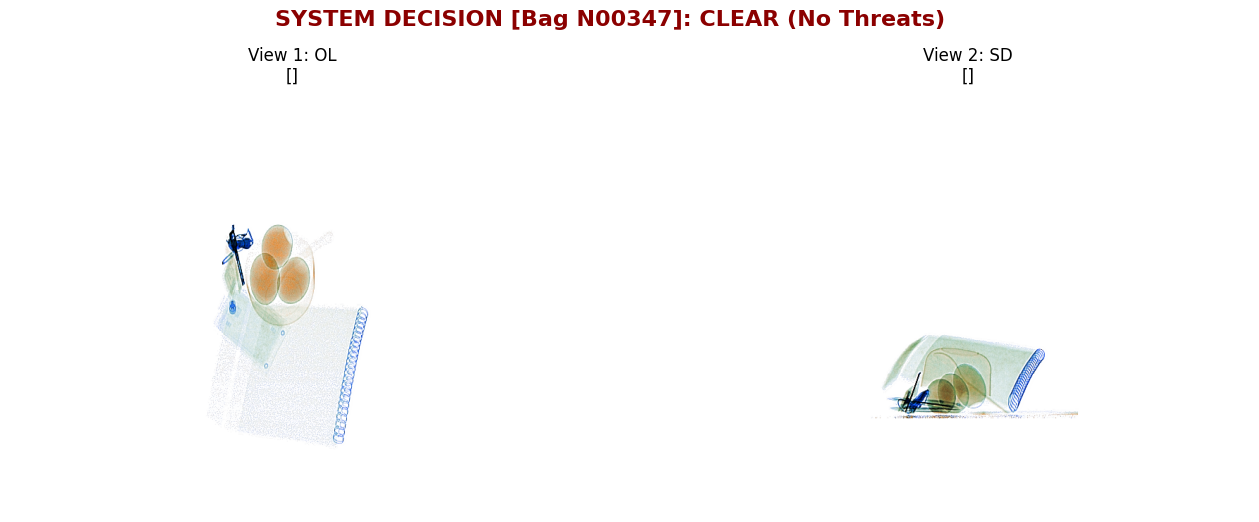

In [22]:
if not pairs:
    print("No pairs found. Check VAL_IMG_DIR path.")
else:
    # Pick a random bag
    sid = random.choice(list(pairs.keys()))
    # sid = "20010915_0045_0099" # Uncomment to test specific ID
    
    res_ol, res_sd, fused_result = run_dual_view_inference(sid, pairs[sid], model)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # View 1: OL
    ax[0].imshow(cv2.cvtColor(res_ol.plot(), cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"View 1: OL\n{list(parse_detections(res_ol, model).keys())}")
    ax[0].axis("off")
    
    # View 2: SD
    ax[1].imshow(cv2.cvtColor(res_sd.plot(), cv2.COLOR_BGR2RGB))
    ax[1].set_title(f"View 2: SD\n{list(parse_detections(res_sd, model).keys())}")
    ax[1].axis("off")
    
    # Final System Decision
    system_decision_str = ", ".join([f"{k} ({v:.2f})" for k, v in fused_result.items()])
    if not system_decision_str: system_decision_str = "CLEAR (No Threats)"
    
    fig.suptitle(f"SYSTEM DECISION [Bag {sid}]: {system_decision_str}", fontsize=16, color='darkred', fontweight='bold')
    plt.show()

#### 5. System Evalutaion
Here we calculate the **System Recall** (Sensitivity) across the entire validation set.
We count an item as "Detected" if it is found in **at least one** of the two views.

In [23]:
# 5. Evaluation Helpers

def get_ground_truth_classes(label_path):
    """Reads a YOLO .txt label file and returns a set of class IDs present."""
    if not os.path.exists(label_path):
        return set()
    
    gt_classes = set()
    with open(label_path, 'r') as f:
        for line in f:
            cls_id = int(line.split()[0])
            gt_classes.add(cls_id)
    return gt_classes

def get_predicted_classes(results):
    """Returns a set of class IDs predicted by the model."""
    pred_classes = set()
    for r in results:
        for box in r.boxes:
            pred_classes.add(int(box.cls[0]))
    return pred_classes

In [24]:
# 6. Run Evaluation Loop

total_gt_items = 0
detected_ol = 0
detected_sd = 0
detected_fused = 0

# Use all pairs found in Step 2
eval_sids = list(pairs.keys())
print(f"Starting evaluation on {len(eval_sids)} bags...")

for sid in tqdm(eval_sids):
    # Get paths from our pairs dict
    path_ol_img = pairs[sid]["OL"]
    path_sd_img = pairs[sid]["SD"]
    
    # Infer label paths from image paths
    # Convention: .../images/val/X.png -> .../labels/val/X.txt
    path_ol_lbl = os.path.join(VAL_LABEL_DIR, f"{sid}_OL.txt")
    path_sd_lbl = os.path.join(VAL_LABEL_DIR, f"{sid}_SD.txt")

    # Get Ground Truth (Union of what is in OL and SD labels)
    gt_ol = get_ground_truth_classes(path_ol_lbl)
    gt_sd = get_ground_truth_classes(path_sd_lbl)
    gt_all = gt_ol | gt_sd
    
    if not gt_all:
        continue # Skip negative samples for Recall calculation

    total_gt_items += len(gt_all)

    # Run Inference (Confidence Threshold 0.25 is standard for metrics)
    res_ol = model.predict(path_ol_img, verbose=False, conf=0.25)
    res_sd = model.predict(path_sd_img, verbose=False, conf=0.25)
    
    preds_ol = get_predicted_classes(res_ol)
    preds_sd = get_predicted_classes(res_sd)
    
    # Late Fusion Logic (Union)
    preds_fused = preds_ol | preds_sd

    # Check for Hits
    for item_id in gt_all:
        if item_id in preds_ol: detected_ol += 1
        if item_id in preds_sd: detected_sd += 1
        if item_id in preds_fused: detected_fused += 1

Starting evaluation on 3200 bags...


100%|██████████| 3200/3200 [00:25<00:00, 126.87it/s]  


In [25]:
# 7. Final Results
if total_gt_items > 0:
    recall_ol = detected_ol / total_gt_items
    recall_sd = detected_sd / total_gt_items
    recall_sys = detected_fused / total_gt_items

    print(f"\n--- MULTI-VIEW SYSTEM PERFORMANCE (N={total_gt_items} items) ---")
    print(f"Single View (OL) Recall: {recall_ol:.2%}")
    print(f"Single View (SD) Recall: {recall_sd:.2%}")
    print(f"Dual View (Fused) Recall: {recall_sys:.2%}")
    
    improvement = (recall_sys - max(recall_ol, recall_sd)) * 100
    print(f"\n>>> Net Improvement: +{improvement:.2f} percentage points")
else:
    print("No positive samples found in the evaluation set.")


--- MULTI-VIEW SYSTEM PERFORMANCE (N=1123 items) ---
Single View (OL) Recall: 86.29%
Single View (SD) Recall: 71.86%
Dual View (Fused) Recall: 91.01%

>>> Net Improvement: +4.72 percentage points


#### 5.2 Per Class Evaluation

In [32]:
CLASS_NAMES = list(model.names.values())
NUM_CLASSES = len(CLASS_NAMES)

In [33]:
# 1. Build Confusion Data
# Logic: For each class, did we detect it correctly?
# Note: Standard CM is for single-label. For multi-label detection, 
# we typically calculate a CM per class or flatten the problem.
# Here we calculate a "Hit/Miss" matrix for visualization.

def get_predicted_classes_set(res_ol, res_sd, conf_thresh=0.25):
    preds = set()
    # View 1
    for box in res_ol.boxes:
        if float(box.conf[0]) > conf_thresh:
            preds.add(int(box.cls[0]))
    # View 2
    for box in res_sd.boxes:
        if float(box.conf[0]) > conf_thresh:
            preds.add(int(box.cls[0]))
    return preds

pairs = get_image_pairs(VAL_IMG_DIR)
eval_sids = list(pairs.keys())

y_true_all = []
y_pred_all = []

print(f"Processing {len(eval_sids)} bags...")

for sid in tqdm(eval_sids):
    # 1. Get Ground Truth (Union of OL/SD labels)
    lbl_ol = os.path.join(VAL_LABEL_DIR, f"{sid}_OL.txt")
    lbl_sd = os.path.join(VAL_LABEL_DIR, f"{sid}_SD.txt")
    gt_set = get_ground_truth_classes(lbl_ol) | get_ground_truth_classes(lbl_sd)
    
    # 2. Get Fused Predictions
    img_ol = pairs[sid]["OL"]
    img_sd = pairs[sid]["SD"]
    
    if not os.path.exists(img_ol) or not os.path.exists(img_sd): continue
        
    res_ol = model.predict(img_ol, verbose=False, conf=0.25)[0]
    res_sd = model.predict(img_sd, verbose=False, conf=0.25)[0]
    pred_set = get_predicted_classes_set(res_ol, res_sd)
    
    # 3. Record Per-Class Results (Binary: Present/Absent)
    # We create a binary vector for this bag: [0, 1, 0, 0 ...]
    # 1 if item exists/detected, 0 otherwise
    
    gt_vec = [1 if i in gt_set else 0 for i in range(NUM_CLASSES)]
    pred_vec = [1 if i in pred_set else 0 for i in range(NUM_CLASSES)]
    
    y_true_all.append(gt_vec)
    y_pred_all.append(pred_vec)

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

Found 3200 complete dual-view pairs.
Processing 3200 bags...


100%|██████████| 3200/3200 [01:05<00:00, 48.67it/s]


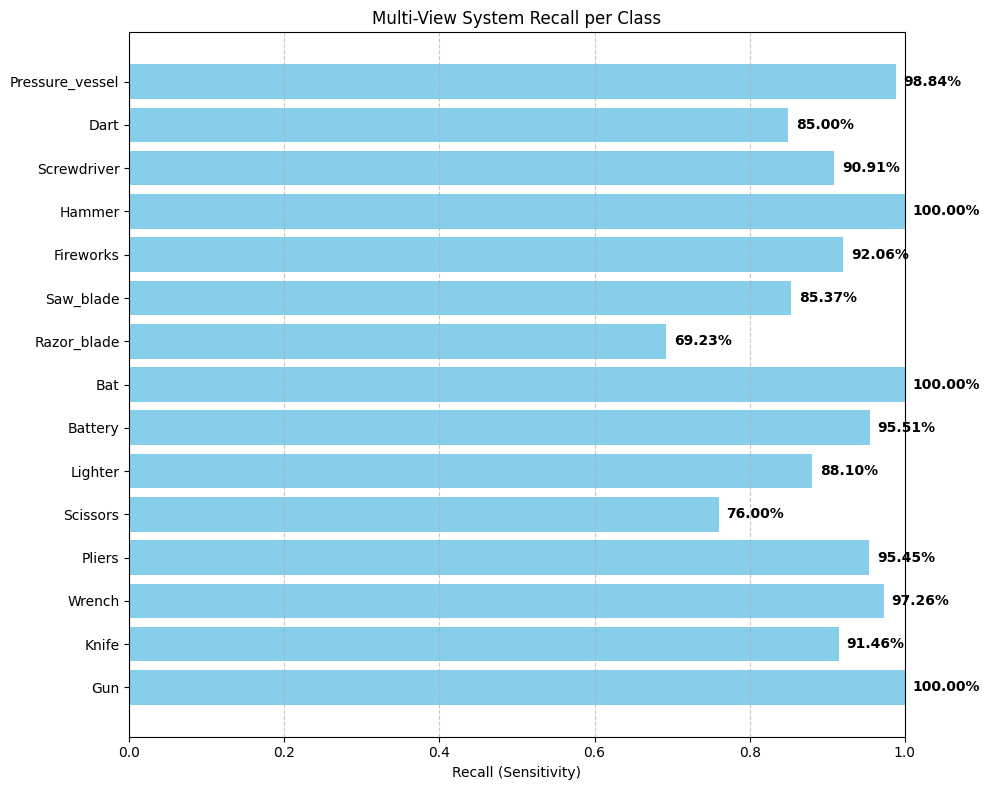

In [34]:
# 2. Plot Confusion Matrix (Normalized Row-wise)
# Since this is multi-label, we can't do a standard N x N matrix easily.
# Instead, visualizing the RECALL per class as a heatmap bar.

class_recall = []
class_precision = []

for i in range(NUM_CLASSES):
    # Extract column for class i
    t = y_true_all[:, i]
    p = y_pred_all[:, i]
    
    # Confusion Matrix for binary class i
    # tn, fp, fn, tp
    cm = confusion_matrix(t, p, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    class_recall.append(recall)
    class_precision.append(precision)

# Plotting
plt.figure(figsize=(10, 8))
y_pos = np.arange(NUM_CLASSES)

plt.barh(y_pos, class_recall, align='center', color='skyblue')
plt.yticks(y_pos, CLASS_NAMES)
plt.xlabel('Recall (Sensitivity)')
plt.title('Multi-View System Recall per Class')
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(class_recall):
    plt.text(v + 0.01, i, f"{v:.2%}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()